In [356]:
import torch
import os
import torchvision.transforms as tfs
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pandas as pd

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchsummary import summary

from pytorch_lightning.metrics.functional import precision_recall
from pytorch_lightning.metrics.functional import accuracy

import time

from tqdm import trange
from colorama import Fore
import time

%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 16, 6

In [258]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    
    train_losses = []
    val_losses = []
    valid_accuracies = []
          
    #train part
    for epoch in range(epochs):
        model.train()
        loss_sum_tr = 0        
        
        for data, target in tqdm((train_dl),
                                 bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.GREEN, Fore.RESET)):
            
            data, target = data.view(data.shape[0],-1).to(device), target.to(device)
            
            loss = loss_func(model(data), target)
            loss_sum_tr += loss.item()
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        train_losses.append(loss_sum_tr / len(train_dl))            
        
       

        #test part
        
        model.eval()
        loss_sum_val = 0
        correct = 0
        num = 0
        
        with torch.no_grad():
            for data_ts, target_ts in valid_dl:
                data_ts, target_ts = data_ts.view(data_ts.shape[0],-1).to(device), target_ts.to(device)
                probs = model(data_ts)
                loss_sum_val += loss_func(model(data_ts), target_ts).item()
                
                
                _, preds = torch.max(probs, axis =-1)
                correct += (preds == target_ts).sum().item()
                num += len(data_ts)
        
        val_losses.append(loss_sum_val / len(valid_dl))
        valid_accuracies.append(correct / num)
                
        print(f'epoch:{int(epoch+1)}\
        \t train loss:{round(loss_sum_tr / len(train_dl),4)}\
        \t valid loss:{round(loss_sum_val/len(valid_dl),4)}\
        \t valid accuracies:({correct} / {num}) {round((correct / num)*100,2)}')
        
    return train_losses, val_losses, valid_accuracies


batch_size = 1000#64
features = 784
classes = 10

device = torch.device("cpu")

In [259]:
def plot_trainig(train_losses, valid_losses, valid_accuracies):
    
    plt.xlabel('epoch')
    plt.plot(train_losses, label='train_loss')
    plt.plot(valid_losses, label='valid_loss')
    plt.legend()
    plt.show()
    
    plt.xlabel('epoch')
    plt.plot(valid_accuracies, label='valid accuracy')
    plt.legend()
    plt.show()

In [260]:
data_tfs = tfs.Compose([tfs.ToTensor()])

In [297]:
train = MNIST('./', train=True, transform=data_tfs, download=True)
test = MNIST('./', train=False, transform=data_tfs, download=True)

train_loader = DataLoader(train, batch_size=batch_size,shuffle=True, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size,shuffle=True, drop_last=True)

data = next(iter(train))
print(f'mean: {data[0].mean().item()} std:{data[0].std().item()}')

print(f'Data size:\n\t train {len(train)},\n\t test {len(test)}')
print(f'Data shape:\n\t features {train[0][0].shape},\n\t target {type(test[0][1])}')

mean: 0.1376800686120987 std:0.3125477433204651
Data size:
	 train 60000,
	 test 10000
Data shape:
	 features torch.Size([1, 28, 28]),
	 target <class 'int'>


In [298]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
    
        self.hidden1 = nn.Linear(features, 64)
        self.hidden2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, classes)
        self.activation = nn.ReLU()

    def forward(self, x):
        
        x = self.hidden1(x)
        x = self.activation(x)
        x = self.hidden2(x)
        x = self.activation(x)
        output = self.output(x)
        return output        
    
summary(Model(), (features,), batch_size=batch_size, device='CPU')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [1000, 64]          50,240
              ReLU-2                 [1000, 64]               0
            Linear-3                 [1000, 32]           2,080
              ReLU-4                 [1000, 32]               0
            Linear-5                 [1000, 10]             330
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 2.99
Forward/backward pass size (MB): 1.54
Params size (MB): 0.20
Estimated Total Size (MB): 4.73
----------------------------------------------------------------


In [1]:
# Run model
model = Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum = 0.9)
info = fit(15, model, criterion, optimizer, train_loader, test_loader)
plot_trainig(*info)

NameError: name 'Model' is not defined

## Normalize data

In [2]:
data_tfs_norm = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.1377), (0.3125))])

NameError: name 'tfs' is not defined

In [ ]:
train_norm = MNIST('./', train=True, transform=data_tfs_norm, download=True,)
test_norm = MNIST('./', train=False, transform=data_tfs_norm, download=True)

train_loader_norm = DataLoader(train_norm, batch_size=batch_size,shuffle=True, drop_last=True)
test_loader_norm = DataLoader(test_norm, batch_size=batch_size,shuffle=True, drop_last=True)

data_norm = next(iter(train_norm))
print(f'mean: {data_norm[0].mean().round().item()} std:{data_norm[0].std().round().item()}')


In [ ]:
# Run model
model = Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum = 0.9)
info = fit(15, model, criterion, optimizer, train_loader_norm, test_loader_norm)
plot_trainig(*info)

## L2

In [3]:
# Run model
model = Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum = 0.9, weight_decay=0.004)
info = fit(15, model, criterion, optimizer, train_loader_norm, test_loader_norm)
plot_trainig(*info)

NameError: name 'Model' is not defined

### Увеличение размера нейронной сети (количества слоёв, количества нейронов в слое)

In [ ]:
class Model2(nn.Module):
    def __init__(self):
        super().__init__()
    
        self.hidden1 = nn.Linear(features, 200)
        self.hidden2 = nn.Linear(200, 150)
        self.hidden3 = nn.Linear(150, 100)
        self.hidden4 = nn.Linear(100, 32)
        self.output = nn.Linear(32, classes)
        self.activation = nn.ReLU()
        
    def forward(self, x):
        
        x = self.hidden1(x)
        x = self.activation(x)
        x = self.hidden2(x)
        x = self.activation(x)
        x = self.hidden3(x)
        x = self.activation(x)
        x = self.hidden4(x)
        x = self.activation(x)
        output = self.output(x)
        return output        
    
summary(Model2(), (features,), batch_size=batch_size, device='CPU')

In [ ]:
# Run model
model = Model2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.15, momentum = 0.9)
info = fit(10, model, criterion, optimizer, train_loader_norm, test_loader_norm)
plot_trainig(*info)

### DropOut, Batch Norm

In [275]:
class ModelDropOut(nn.Module):
    def __init__(self):
        super().__init__()
    
        self.hidden1 = nn.Linear(features, 64)
        self.hidden2 = nn.Linear(64, 32)
        self.dropout = nn.Dropout(p=0.2)
        self.output = nn.Linear(32, classes)
        self.activation = nn.ReLU()

    def forward(self, x):
        
        x = self.hidden1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.hidden2(x)
        x = self.activation(x)
        x = self.dropout(x)
        output = self.output(x)
        return output        
    
summary(ModelDropOut(), (features,), batch_size=batch_size, device='CPU')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [1000, 64]          50,240
              ReLU-2                 [1000, 64]               0
           Dropout-3                 [1000, 64]               0
            Linear-4                 [1000, 32]           2,080
              ReLU-5                 [1000, 32]               0
           Dropout-6                 [1000, 32]               0
            Linear-7                 [1000, 10]             330
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 2.99
Forward/backward pass size (MB): 2.27
Params size (MB): 0.20
Estimated Total Size (MB): 5.47
----------------------------------------------------------------


  2%|█▍                                                                                 | 1/60 [00:00<00:10,  5.63it/s]

epoch:1        	 train loss:1.1625        	 valid loss:0.3232        	 valid accuracies:(9093 / 10000) 90.93


  2%|█▍                                                                                 | 1/60 [00:00<00:10,  5.76it/s]

epoch:2        	 train loss:0.591        	 valid loss:0.244        	 valid accuracies:(9278 / 10000) 92.78


  2%|█▍                                                                                 | 1/60 [00:00<00:10,  5.82it/s]

epoch:3        	 train loss:0.5126        	 valid loss:0.2221        	 valid accuracies:(9348 / 10000) 93.48


  2%|█▍                                                                                 | 1/60 [00:00<00:11,  5.35it/s]

epoch:4        	 train loss:0.4566        	 valid loss:0.1999        	 valid accuracies:(9449 / 10000) 94.49


  0%|                                                                                           | 0/60 [00:00<?, ?it/s]

epoch:5        	 train loss:0.4371        	 valid loss:0.196        	 valid accuracies:(9448 / 10000) 94.48


  2%|█▍                                                                                 | 1/60 [00:00<00:10,  5.56it/s]

epoch:6        	 train loss:0.4186        	 valid loss:0.1867        	 valid accuracies:(9486 / 10000) 94.86


  2%|█▍                                                                                 | 1/60 [00:00<00:10,  5.65it/s]

epoch:7        	 train loss:0.3988        	 valid loss:0.177        	 valid accuracies:(9504 / 10000) 95.04


  2%|█▍                                                                                 | 1/60 [00:00<00:10,  5.76it/s]

epoch:8        	 train loss:0.3891        	 valid loss:0.1787        	 valid accuracies:(9496 / 10000) 94.96


  2%|█▍                                                                                 | 1/60 [00:00<00:10,  5.56it/s]

epoch:9        	 train loss:0.3857        	 valid loss:0.1692        	 valid accuracies:(9536 / 10000) 95.36


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:11<00:00,  5.45it/s]


epoch:10        	 train loss:0.3781        	 valid loss:0.1681        	 valid accuracies:(9532 / 10000) 95.32


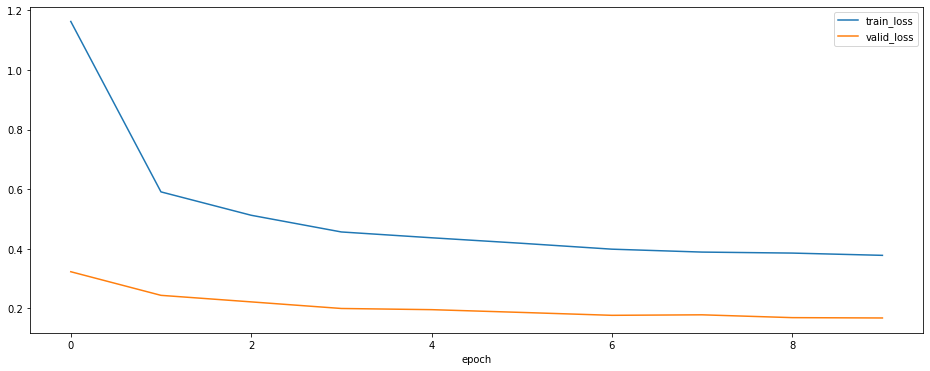

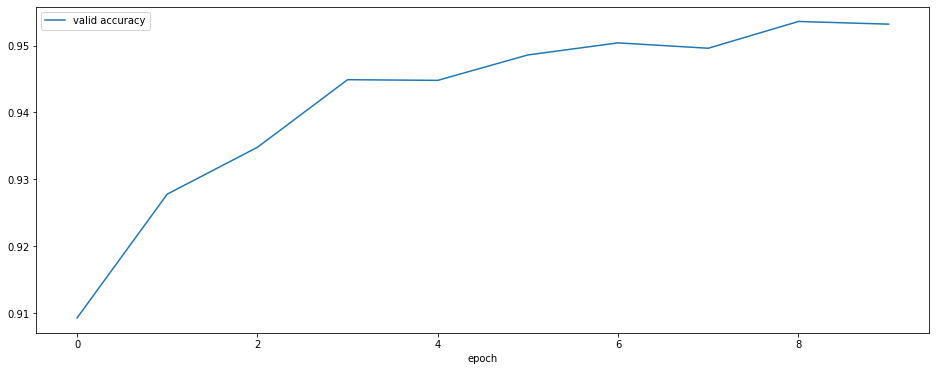

In [276]:
# Run model
model = ModelDropOut().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum = 0.9)
info = fit(10, model, criterion, optimizer, train_loader_norm, test_loader_norm)
plot_trainig(*info)

In [295]:
class ModelBatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
    
        self.hidden1 = nn.Linear(features, 64)
        self.hidden2 = nn.Linear(64, 32)
        self.bn = nn.BatchNorm1d(32)
        self.output = nn.Linear(32, classes)
        self.activation = nn.ReLU()

    def forward(self, x):
        
        x = self.hidden1(x)
        x = self.activation(x)
        x = self.hidden2(x)
        x = self.activation(x)
        x = self.bn(x)
        output = self.output(x)
        return output        
    
summary(ModelBatchNorm(), (features,), batch_size=batch_size, device='CPU')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [1000, 64]          50,240
              ReLU-2                 [1000, 64]               0
            Linear-3                 [1000, 32]           2,080
              ReLU-4                 [1000, 32]               0
       BatchNorm1d-5                 [1000, 32]              64
            Linear-6                 [1000, 10]             330
Total params: 52,714
Trainable params: 52,714
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 2.99
Forward/backward pass size (MB): 1.79
Params size (MB): 0.20
Estimated Total Size (MB): 4.98
----------------------------------------------------------------


  2%|█▍                                                                                 | 1/60 [00:00<00:10,  5.68it/s]

epoch:1        	 train loss:0.4552        	 valid loss:0.1926        	 valid accuracies:(9418 / 10000) 94.18


  2%|█▍                                                                                 | 1/60 [00:00<00:10,  5.49it/s]

epoch:2        	 train loss:0.16        	 valid loss:0.1356        	 valid accuracies:(9573 / 10000) 95.73


  2%|█▍                                                                                 | 1/60 [00:00<00:10,  5.56it/s]

epoch:3        	 train loss:0.1127        	 valid loss:0.1098        	 valid accuracies:(9650 / 10000) 96.5


  2%|█▍                                                                                 | 1/60 [00:00<00:10,  5.87it/s]

epoch:4        	 train loss:0.0888        	 valid loss:0.0977        	 valid accuracies:(9687 / 10000) 96.87


  2%|█▍                                                                                 | 1/60 [00:00<00:11,  5.21it/s]

epoch:5        	 train loss:0.0725        	 valid loss:0.094        	 valid accuracies:(9709 / 10000) 97.09


  2%|█▍                                                                                 | 1/60 [00:00<00:10,  5.39it/s]

epoch:6        	 train loss:0.0602        	 valid loss:0.0998        	 valid accuracies:(9687 / 10000) 96.87


  2%|█▍                                                                                 | 1/60 [00:00<00:10,  5.50it/s]

epoch:7        	 train loss:0.0508        	 valid loss:0.1019        	 valid accuracies:(9705 / 10000) 97.05


  2%|█▍                                                                                 | 1/60 [00:00<00:11,  5.28it/s]

epoch:8        	 train loss:0.0437        	 valid loss:0.1036        	 valid accuracies:(9700 / 10000) 97.0


  2%|█▍                                                                                 | 1/60 [00:00<00:10,  5.51it/s]

epoch:9        	 train loss:0.038        	 valid loss:0.0997        	 valid accuracies:(9726 / 10000) 97.26


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.45it/s]


epoch:10        	 train loss:0.0329        	 valid loss:0.1        	 valid accuracies:(9728 / 10000) 97.28


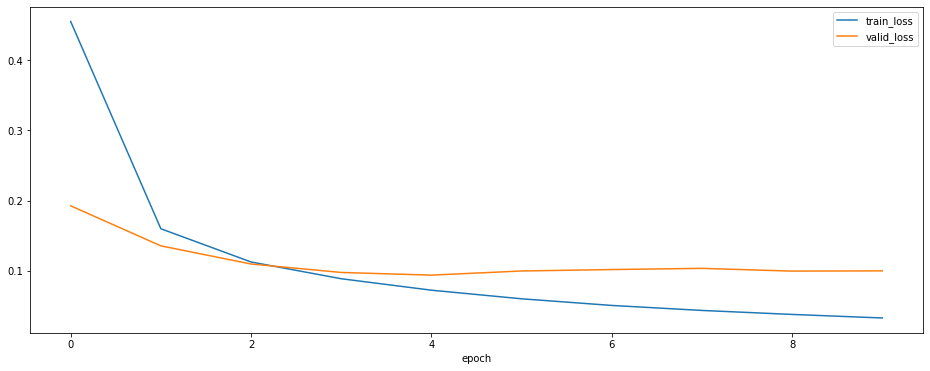

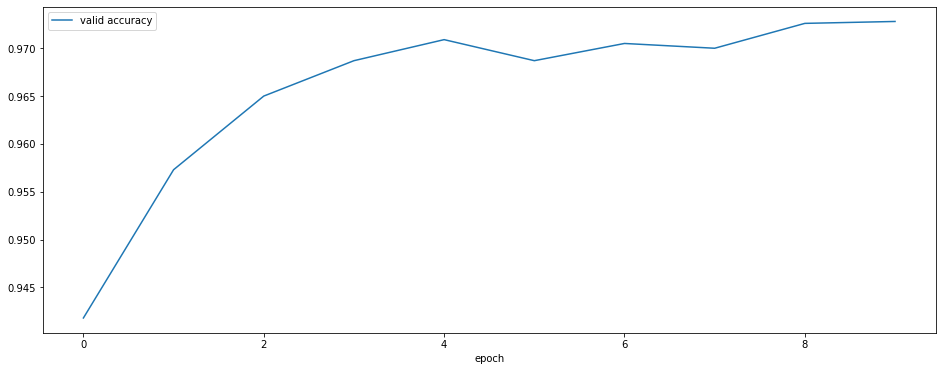

In [296]:
# Run model
model = ModelBatchNorm().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum = 0.9)
info = fit(10, model, criterion, optimizer, train_loader_norm, test_loader_norm)
plot_trainig(*info)

## Data Augmentation

In [352]:
data_tfs_ag = tfs.Compose([
    tfs.ToTensor(),
    tfs.RandomHorizontalFlip(p=0.5),
    #tfs.RandomRotation(degrees=45),
    tfs.RandomVerticalFlip(p=0.5),
    tfs.Normalize((0.1377), (0.3125))])

In [353]:
train_ag = MNIST('./', train=True, transform=data_tfs_ag, download=True,)
test_ag = MNIST('./', train=False, transform=data_tfs_ag, download=True)

train_loader_ag = DataLoader(train_ag, batch_size=batch_size,shuffle=True, drop_last=True)
test_loader_ag = DataLoader(test_ag, batch_size=batch_size,shuffle=True, drop_last=True)

data_ag = next(iter(train_norm))
print(f'mean: {data_ag[0].mean().round().item()} std:{data_ag[0].std().round().item()}')


mean: -0.0 std:1.0


  0%|                                                                                           | 0/60 [00:00<?, ?it/s]

epoch:1        	 train loss:1.4771        	 valid loss:1.0136        	 valid accuracies:(7007 / 10000) 70.07


  0%|                                                                                           | 0/60 [00:00<?, ?it/s]

epoch:2        	 train loss:0.8668        	 valid loss:0.7099        	 valid accuracies:(8001 / 10000) 80.01


  0%|                                                                                           | 0/60 [00:00<?, ?it/s]

epoch:3        	 train loss:0.6325        	 valid loss:0.5367        	 valid accuracies:(8507 / 10000) 85.07


  0%|                                                                                           | 0/60 [00:00<?, ?it/s]

epoch:4        	 train loss:0.5021        	 valid loss:0.4451        	 valid accuracies:(8744 / 10000) 87.44


  0%|                                                                                           | 0/60 [00:00<?, ?it/s]

epoch:5        	 train loss:0.4249        	 valid loss:0.3916        	 valid accuracies:(8853 / 10000) 88.53


  0%|                                                                                           | 0/60 [00:00<?, ?it/s]

epoch:6        	 train loss:0.3765        	 valid loss:0.3484        	 valid accuracies:(8970 / 10000) 89.7


  0%|                                                                                           | 0/60 [00:00<?, ?it/s]

epoch:7        	 train loss:0.3415        	 valid loss:0.335        	 valid accuracies:(8985 / 10000) 89.85


  0%|                                                                                           | 0/60 [00:00<?, ?it/s]

epoch:8        	 train loss:0.3173        	 valid loss:0.3029        	 valid accuracies:(9068 / 10000) 90.68


  0%|                                                                                           | 0/60 [00:00<?, ?it/s]

epoch:9        	 train loss:0.2941        	 valid loss:0.2926        	 valid accuracies:(9130 / 10000) 91.3


  0%|                                                                                           | 0/60 [00:00<?, ?it/s]

epoch:10        	 train loss:0.2769        	 valid loss:0.2717        	 valid accuracies:(9179 / 10000) 91.79


  0%|                                                                                           | 0/60 [00:00<?, ?it/s]

epoch:11        	 train loss:0.2636        	 valid loss:0.268        	 valid accuracies:(9174 / 10000) 91.74


  0%|                                                                                           | 0/60 [00:00<?, ?it/s]

epoch:12        	 train loss:0.2503        	 valid loss:0.2533        	 valid accuracies:(9250 / 10000) 92.5


  0%|                                                                                           | 0/60 [00:00<?, ?it/s]

epoch:13        	 train loss:0.2405        	 valid loss:0.2445        	 valid accuracies:(9262 / 10000) 92.62


  0%|                                                                                           | 0/60 [00:00<?, ?it/s]

epoch:14        	 train loss:0.2328        	 valid loss:0.2374        	 valid accuracies:(9284 / 10000) 92.84


  0%|                                                                                           | 0/60 [00:00<?, ?it/s]

epoch:15        	 train loss:0.2255        	 valid loss:0.2359        	 valid accuracies:(9270 / 10000) 92.7


  0%|                                                                                           | 0/60 [00:00<?, ?it/s]

epoch:16        	 train loss:0.2176        	 valid loss:0.2261        	 valid accuracies:(9304 / 10000) 93.04


  0%|                                                                                           | 0/60 [00:00<?, ?it/s]

epoch:17        	 train loss:0.2129        	 valid loss:0.2318        	 valid accuracies:(9272 / 10000) 92.72


  0%|                                                                                           | 0/60 [00:00<?, ?it/s]

epoch:18        	 train loss:0.206        	 valid loss:0.2234        	 valid accuracies:(9311 / 10000) 93.11


  0%|                                                                                           | 0/60 [00:00<?, ?it/s]

epoch:19        	 train loss:0.2006        	 valid loss:0.2239        	 valid accuracies:(9293 / 10000) 92.93


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:18<00:00,  3.32it/s]


epoch:20        	 train loss:0.1949        	 valid loss:0.2152        	 valid accuracies:(9334 / 10000) 93.34


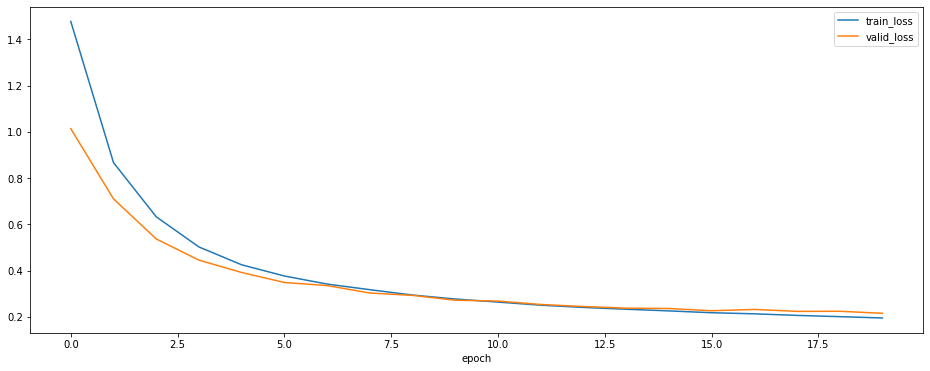

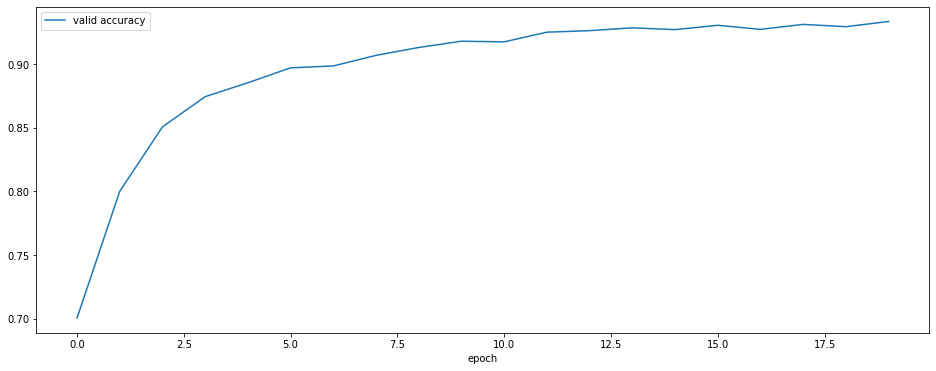

In [354]:
# Run model
model = ModelBatchNorm().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum = 0.9)
info = fit(20, model, criterion, optimizer, train_loader_ag, test_loader_ag)
plot_trainig(*info)

## Early Stopping

In [380]:
import numpy as np


In [386]:
def FitEarlyStopping(epochs, model, loss_func, opt, train_dl, valid_dl):
    min_val_loss = np.Inf
    n_epochs_stop = 20
    epochs_no_improve = 0
    early_stop = False
    iter = 0
    
    train_losses = []
    val_losses = []
    valid_accuracies = []
          
    #train part
    for epoch in range(epochs):
        model.train()
        loss_sum_tr = 0        
        
        for data, target in tqdm((train_dl),
                                 bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.GREEN, Fore.RESET)):
            
            data, target = data.view(data.shape[0],-1).to(device), target.to(device)
            
            loss = loss_func(model(data), target)
            loss_sum_tr += loss.item()
            val_loss = loss_sum_tr / len(data)
            loss.backward()
            opt.step()
            opt.zero_grad()
            

            
            ############################################
            if val_loss < min_val_loss:
                epochs_no_improve = 0
                min_val_loss = val_loss
            
            else:
                epochs_no_improve += 1
            iter += 1
            if epoch > 5 and epochs_no_improve == n_epochs_stop:
                print('Early stopping!' )
                early_stop = True
                break
            else:
                continue
            break
            
            if iter % 336 == 0:
                # Calculate Accuracy
                correct = 0
                total = 0
                #print(iter)
                # Iterate through test dataset
    # Check early stopping condition
        
        if early_stop:
            print("Stopped")
            break
        
        train_losses.append(loss_sum_tr / len(train_dl))

        #test part
        
        model.eval()
        loss_sum_val = 0
        correct = 0
        num = 0
        
        with torch.no_grad():
            for data_ts, target_ts in valid_dl:
                data_ts, target_ts = data_ts.view(data_ts.shape[0],-1).to(device), target_ts.to(device)
                probs = model(data_ts)
                loss_sum_val += loss_func(model(data_ts), target_ts).item()
                
                
                _, preds = torch.max(probs, axis =-1)
                correct += (preds == target_ts).sum().item()
                num += len(data_ts)
        
        val_losses.append(loss_sum_val / len(valid_dl))
        valid_accuracies.append(correct / num)
                
        print(f'epoch:{int(epoch+1)}\
        \t train loss:{round(loss_sum_tr / len(train_dl),4)}\
        \t valid loss:{round(loss_sum_val/len(valid_dl),4)}\
        \t valid accuracies:({correct} / {num}) {round((correct / num)*100,2)}')
        
    return train_losses, val_losses, valid_accuracies


  2%|█▍                                                                                 | 1/60 [00:00<00:10,  5.53it/s]

epoch:1        	 train loss:1.0419        	 valid loss:0.5027        	 valid accuracies:(8937 / 10000) 89.37


  2%|█▍                                                                                 | 1/60 [00:00<00:10,  5.54it/s]

epoch:2        	 train loss:0.3993        	 valid loss:0.3159        	 valid accuracies:(9260 / 10000) 92.6


  2%|█▍                                                                                 | 1/60 [00:00<00:09,  6.06it/s]

epoch:3        	 train loss:0.2767        	 valid loss:0.2405        	 valid accuracies:(9385 / 10000) 93.85


  2%|█▍                                                                                 | 1/60 [00:00<00:10,  5.60it/s]

epoch:4        	 train loss:0.2169        	 valid loss:0.1985        	 valid accuracies:(9491 / 10000) 94.91


  2%|█▍                                                                                 | 1/60 [00:00<00:11,  5.13it/s]

epoch:5        	 train loss:0.1792        	 valid loss:0.1712        	 valid accuracies:(9549 / 10000) 95.49


  2%|█▍                                                                                 | 1/60 [00:00<00:11,  5.18it/s]

epoch:6        	 train loss:0.1534        	 valid loss:0.1509        	 valid accuracies:(9582 / 10000) 95.82


 33%|███████████████████████████▎                                                      | 20/60 [00:03<00:07,  5.05it/s]

Early stopping!
Stopped


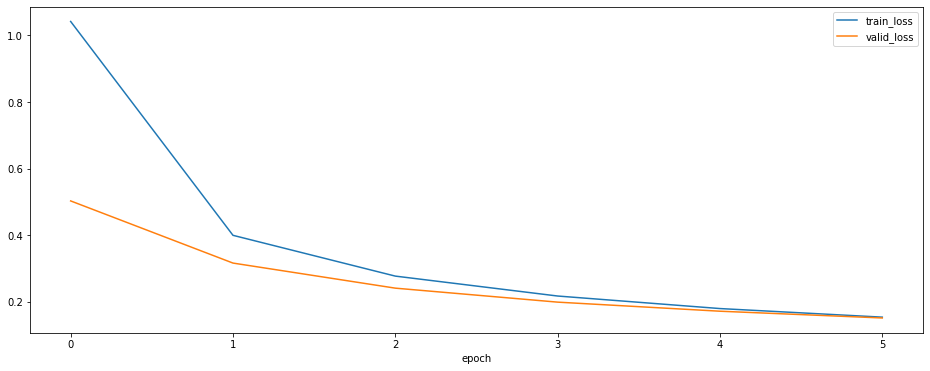

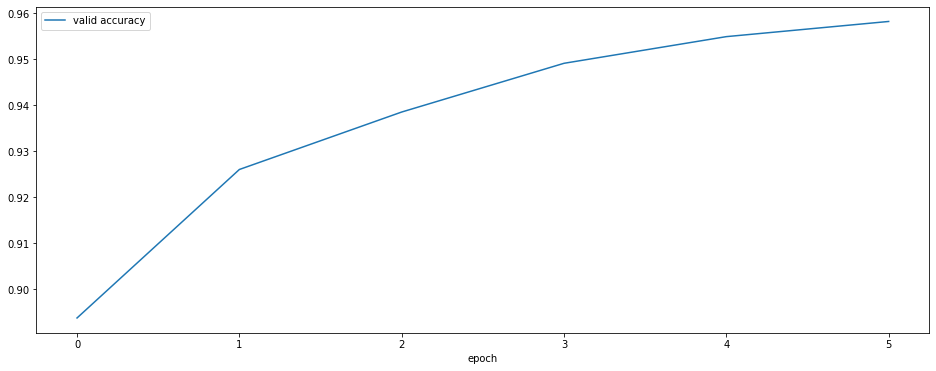

In [387]:
# Run model
model = ModelBatchNorm().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum = 0.9)
info = FitEarlyStopping(20, model, criterion, optimizer, train_loader_norm, test_loader_norm)
plot_trainig(*info)

## Reduce LR on Plateau or other LR schedulers

In [398]:
def FitSchedulers(epochs, model, loss_func, opt, train_dl, valid_dl, lr_sched=None):
        
    train_losses = []
    val_losses = []
    valid_accuracies = []
          
    #train part
    for epoch in range(epochs):
        model.train()
        loss_sum_tr = 0        
        
        for data, target in tqdm((train_dl),
                                 bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.GREEN, Fore.RESET)):
            
            data, target = data.view(data.shape[0],-1).to(device), target.to(device)
            
            loss = loss_func(model(data), target)
            loss_sum_tr += loss.item()
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        train_losses.append(loss_sum_tr / len(train_dl))            
        
       

        #test part
        
        model.eval()
        loss_sum_val = 0
        correct = 0
        num = 0
        
        with torch.no_grad():
            for data_ts, target_ts in valid_dl:
                data_ts, target_ts = data_ts.view(data_ts.shape[0],-1).to(device), target_ts.to(device)
                probs = model(data_ts)
                loss_sum_val += loss_func(model(data_ts), target_ts).item()
                
                
                _, preds = torch.max(probs, axis =-1)
                correct += (preds == target_ts).sum().item()
                num += len(data_ts)
        
        val_losses.append(loss_sum_val / len(valid_dl))
        valid_accuracies.append(correct / num)
                
        print(f'epoch:{int(epoch+1)}\
        \t train loss:{round(loss_sum_tr / len(train_dl),4)}\
        \t valid loss:{round(loss_sum_val/len(valid_dl),4)}\
        \t valid accuracies:({correct} / {num}) {round((correct / num)*100,2)}')
        
        
        if lr_sched is not None:
            lr_sched.step()
        
        
    return train_losses, val_losses, valid_accuracies
 
    


  2%|█▍                                                                                 | 1/60 [00:00<00:10,  5.46it/s]

epoch:1        	 train loss:0.8315        	 valid loss:0.3557        	 valid accuracies:(9115 / 10000) 91.15


  0%|                                                                                           | 0/60 [00:00<?, ?it/s]

epoch:2        	 train loss:0.2897        	 valid loss:0.2328        	 valid accuracies:(9375 / 10000) 93.75


  2%|█▍                                                                                 | 1/60 [00:00<00:10,  5.46it/s]

epoch:3        	 train loss:0.2053        	 valid loss:0.1804        	 valid accuracies:(9506 / 10000) 95.06


  2%|█▍                                                                                 | 1/60 [00:00<00:10,  5.49it/s]

epoch:4        	 train loss:0.1628        	 valid loss:0.1516        	 valid accuracies:(9593 / 10000) 95.93


  2%|█▍                                                                                 | 1/60 [00:00<00:11,  5.32it/s]

epoch:5        	 train loss:0.135        	 valid loss:0.1335        	 valid accuracies:(9635 / 10000) 96.35


  2%|█▍                                                                                 | 1/60 [00:00<00:10,  5.52it/s]

epoch:6        	 train loss:0.116        	 valid loss:0.1233        	 valid accuracies:(9652 / 10000) 96.52


  2%|█▍                                                                                 | 1/60 [00:00<00:10,  5.56it/s]

epoch:7        	 train loss:0.1009        	 valid loss:0.1139        	 valid accuracies:(9683 / 10000) 96.83


  2%|█▍                                                                                 | 1/60 [00:00<00:11,  5.34it/s]

epoch:8        	 train loss:0.0883        	 valid loss:0.1091        	 valid accuracies:(9668 / 10000) 96.68


  2%|█▍                                                                                 | 1/60 [00:00<00:11,  5.35it/s]

epoch:9        	 train loss:0.0792        	 valid loss:0.1076        	 valid accuracies:(9682 / 10000) 96.82


  2%|█▍                                                                                 | 1/60 [00:00<00:10,  5.46it/s]

epoch:10        	 train loss:0.0711        	 valid loss:0.1014        	 valid accuracies:(9697 / 10000) 96.97


  2%|█▍                                                                                 | 1/60 [00:00<00:10,  5.49it/s]

epoch:11        	 train loss:0.0638        	 valid loss:0.0966        	 valid accuracies:(9715 / 10000) 97.15


  2%|█▍                                                                                 | 1/60 [00:00<00:10,  5.41it/s]

epoch:12        	 train loss:0.0576        	 valid loss:0.093        	 valid accuracies:(9722 / 10000) 97.22


  2%|█▍                                                                                 | 1/60 [00:00<00:10,  5.65it/s]

epoch:13        	 train loss:0.0529        	 valid loss:0.0941        	 valid accuracies:(9721 / 10000) 97.21


  2%|█▍                                                                                 | 1/60 [00:00<00:10,  5.43it/s]

epoch:14        	 train loss:0.0484        	 valid loss:0.0903        	 valid accuracies:(9737 / 10000) 97.37


  2%|█▍                                                                                 | 1/60 [00:00<00:10,  5.52it/s]

epoch:15        	 train loss:0.0441        	 valid loss:0.0913        	 valid accuracies:(9728 / 10000) 97.28


  2%|█▍                                                                                 | 1/60 [00:00<00:10,  5.38it/s]

epoch:16        	 train loss:0.0406        	 valid loss:0.0884        	 valid accuracies:(9724 / 10000) 97.24


  2%|█▍                                                                                 | 1/60 [00:00<00:10,  5.40it/s]

epoch:17        	 train loss:0.0371        	 valid loss:0.0876        	 valid accuracies:(9733 / 10000) 97.33


  2%|█▍                                                                                 | 1/60 [00:00<00:11,  4.95it/s]

epoch:18        	 train loss:0.0346        	 valid loss:0.0888        	 valid accuracies:(9731 / 10000) 97.31


  2%|█▍                                                                                 | 1/60 [00:00<00:10,  5.38it/s]

epoch:19        	 train loss:0.0315        	 valid loss:0.0927        	 valid accuracies:(9719 / 10000) 97.19


  2%|█▍                                                                                 | 1/60 [00:00<00:10,  5.56it/s]

epoch:20        	 train loss:0.029        	 valid loss:0.0862        	 valid accuracies:(9746 / 10000) 97.46


  2%|█▍                                                                                 | 1/60 [00:00<00:10,  5.49it/s]

epoch:21        	 train loss:0.0262        	 valid loss:0.0881        	 valid accuracies:(9745 / 10000) 97.45


  0%|                                                                                           | 0/60 [00:00<?, ?it/s]

epoch:22        	 train loss:0.0243        	 valid loss:0.0893        	 valid accuracies:(9724 / 10000) 97.24


  2%|█▍                                                                                 | 1/60 [00:00<00:10,  5.43it/s]

epoch:23        	 train loss:0.0229        	 valid loss:0.0868        	 valid accuracies:(9737 / 10000) 97.37


  2%|█▍                                                                                 | 1/60 [00:00<00:11,  5.18it/s]

epoch:24        	 train loss:0.0204        	 valid loss:0.084        	 valid accuracies:(9744 / 10000) 97.44


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:11<00:00,  5.28it/s]


epoch:25        	 train loss:0.0188        	 valid loss:0.0846        	 valid accuracies:(9745 / 10000) 97.45


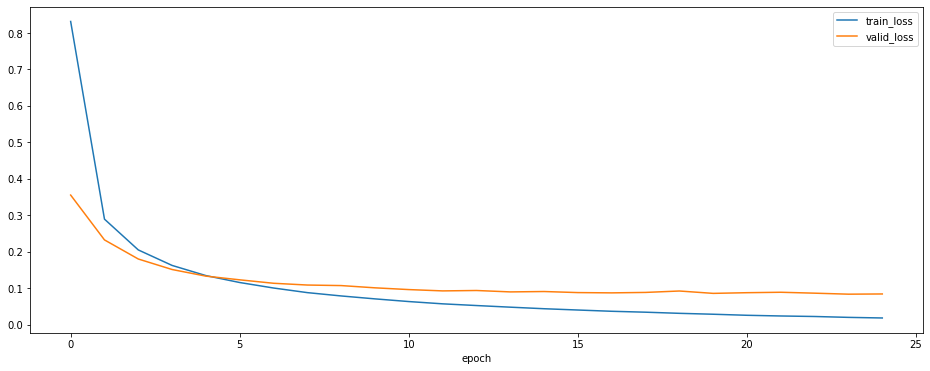

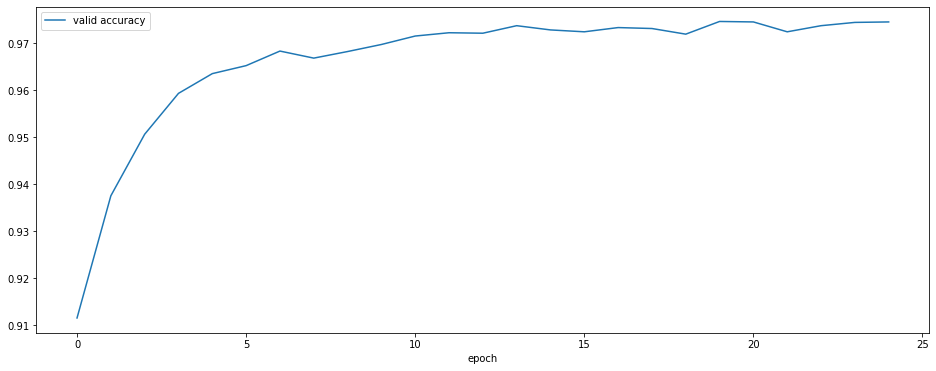

In [399]:
# Run model
model = ModelBatchNorm().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum = 0.9)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.5)
info = FitSchedulers(25, model, criterion, optimizer, train_loader_norm, test_loader_norm)
plot_trainig(*info)

## Best Weights